### 1. 사이킷런을 사용한 k-평균 군집

- **K-평균(K-means) 군집: 데이터의 평균/가장 자주 등장하는 특성으로 객체를 묶는 것**
- 활용: 문서/음악/영화 주제별 grouping, 구매 이력의 공통 특성을 갖는 고객 grouping
- 단점: k 그룹의 수를 사전에 지정해야하며 k가 적절하지 않으면 군집 성능이 나쁘다
 - 보통 elbow 방법을 통해 최적화 그룹 수 k를 구하고 진행하기도 함

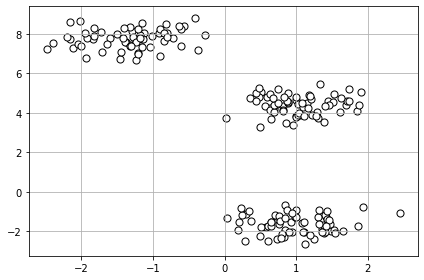

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, 
                  n_features=3,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

import matplotlib.pyplot as plt

plt.scatter(X[:, 0],
            X[:, 1],
           c='white',
           marker='o',
           edgecolor='black',
           s=50)

plt.grid()
plt.tight_layout()
plt.show()

In [6]:
make_blobs # 어떤 모듈인지 확인: default 값 확인 가능

<function sklearn.datasets._samples_generator.make_blobs(n_samples=100, n_features=2, *, centers=None, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None, return_centers=False)>

### 2. K-means 모듈 import 하기

- 유클리디안 거리지표를 기반으로 k-평균 알고리즘 활용됨
- 클러스터 내 제곱 오차합(SSE) or 클러스터 관성(cluster inertia)을 반복적으로 최소화하는 방법
- `n_init`: 각기 다른 랜덤한 센트로이드에서 독립적으로 n번 실행하여 가장 낮은 SSE를 만드는 1개를 최종 모델로 선택
- `max_iter`: 1번의 실행에서 수행할 최대 반복 횟수 (k-평균은 최대 반복횟수 전에 수렴하면 일찍 종료됨)
- `tol`: 수렴을 결정하는 클러스터 내 제곱 오차합의 변화량에 대한 허용 오차 조정

In [10]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
          init='random',
          n_init=10,
          max_iter=300,
          tol = 1e-04,
          random_state=0)

y_km = km.fit_predict(X)

#### **시각화**

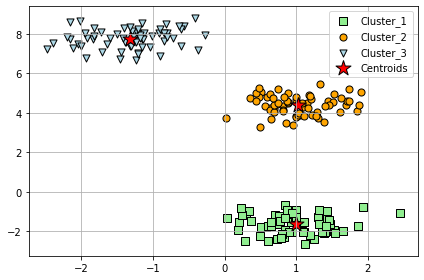

In [11]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster_1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster_2')

plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster_3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, c='red',
            marker='*', edgecolor='black',
            label='Centroids')

plt.legend(scatterpoints=1) # 범례
plt.grid() # 눈금선 표시
plt.tight_layout()
plt.show()

#### - 원형 중심부에 3개 센트로이드 할당한 것 확인
- k-means 작은 데이터셋에서 잘 작동함

### 3. 최적의 클러스터 개수 찾기 - Elbow 방법

In [19]:
print('왜곡: %.2f'% km.inertia_)

왜곡: 71.74


C:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


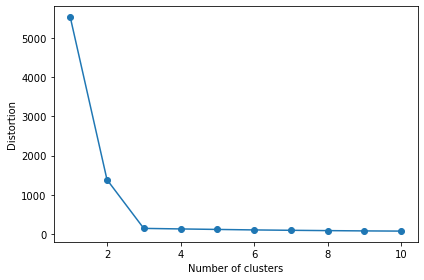

In [21]:
distortions = [] # 클러스터 내 SSE 관성 or 왜곡
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)

    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

- 위 그래프에서는 k=3 이 최적값

### 4. 최적의 클러스터 개수 찾기 - 실루엣계수
- 실루엣계수(Silhouette coefficient): `-1과 1 사이의 값`
- 원형 클러스터가 아닌 경우 잘 맞지 않음
- 계산 원리: 
 - `a(i)`: 샘플 x(i)와 클러스터 내 모든 다른 포인트 사이의 거리를 평균 (**클러스터 응집력**) 
 - `b(i)`: 샘플 x(i)와 가장 가까운 클러스터의 모든 샘플 간 평균 거리, 최근접 클러스터의 (**클러스터 분리도**)
 - 실루엣 `s(i)` = `b(i)-a(i) / max{b(i), a(i}`
 
- sklearn.metrics의  `silhouette_samples` or `silhouette_scores`로 확인 가능

In [23]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state = 0)

y_km = km.fit_predict(X)

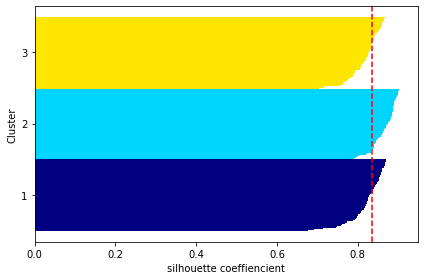

In [26]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height = 1.0,
             edgecolor='none',
             color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coeffiencient')
plt.tight_layout()
plt.show()

#### => 실루엣 값이 0에서 멀리 떨어져 있기에 군집이 잘 된 것을 알 수 있음